In [1]:
import pandas as pd

df = pd.read_csv("annotations.csv", sep=',')

In [2]:
# We have four annotated columns, each corresponding to an investigative question
cols = df.columns.tolist()
cols.remove("Dokument")
cols

['Hvem har tilknytning til åstedet / gjerningsadressen? ',
 'Hva har skjedd - dødsårsak',
 'Var fornærmede involvert i konflikt?',
 'Drapsvåpenet, hva vet vi om drapsvåpenet?']

In [3]:
def has_value(row):
    # check if there's any string in this row:
    return any([isinstance(row[col], str) for col in cols])

df["has_value"] = df.apply(has_value, axis=1)
df.head()

df["has_value"].value_counts()

has_value
False    98
True     37
Name: count, dtype: int64

In [4]:
# mapping from ColumnName -> IBn
col_to_ib = {}
ibs = ["IB1", "IB2", "IB3", "IB4"]
for ib, col in zip(ibs, cols):
    col_to_ib[col] = ib
ib_to_col = {v: k for k, v in col_to_ib.items()}

to_dict = {}

# the paragraph index is just the index of the dataframe
for i in df.index:
    # create a dictionary for each paragraph
    to_dict[i] = {}
    # iterate over the columns
    for col in cols:
        # if the value is not NaN, add it to the dictionary
        if not pd.isna(df.loc[i, col]):
            _id = col_to_ib[col]
            to_dict[i][_id] = df.loc[i, col]

# remove empty
to_dict = {k: v for k, v in to_dict.items() if v}

In [5]:
rename_map = {col: col_to_ib[col] for col in cols}
df = df.rename(columns=rename_map)
df.head()

,Dokument,IB1,IB2,IB3,IB4,has_value
0,B er tiltalt for overtredelse av straffeloven ...,NaN,NaN,NaN,NaN,False
1,"Etter den umiddelbare bevisførselen i saken, o...",NaN,NaN,NaN,NaN,False
2,Torsdag den 7. november 2013 klokken 0950 mott...,NaN,NaN,NaN,NaN,False
3,Temperaturen i Bergen den aktuelle natten var ...,NaN,NaN,NaN,NaN,False
4,"Avdøde var våt, kald og stiv da han ble funnet...",NaN,"Avdøde var blodtilsølt på magen, hendene, arme...",NaN,NaN,True


In [6]:
# df where IB4 is not NaN
df[df["IB4"].notna()].IB4.tolist()


['avdøde ble stukket med en saks',
 'Doktor Morild fremholdt at mange av stikkskadene var litt uregelmessige og ikke helt karakteristiske for en vanlig kniv. Han fremholdt at en saks kunne være brukt.',
 'A beskrev saksen som ganske stor. Han forklarte videre at den hadde et gult håndtak. A er blitt vist en saks med lilla håndtak som ble funnet på verandaen, og som politiet mener kan ha vært brukt til drapet. A mente imidlertid at det ikke var saksen med lilla håndtak B brukte til å stikke avdøde med.',
 'Videre ødela B saksen ved at han delte den i flere biter, og kastet den.',
 'Politiet har ikke funnet en saks med gult håndtak slik A har forklart. Det har vært leitet både med hund og metalldetektor etter dette. Det er imidlertid beslaglagt en saks med lilla håndtak på verandaen under en bosspose. På saksen var det fettlignende avsetninger på mesteparten av bladet. Det er tatt avstryk og Kripos har undersøkt saksen. Det fremkommer identisk DNA-profil som avdøde. Den saksen som er fun

In [7]:
def column_statistics(colname):
    col = df[colname]
    print("Column: {}".format(colname))
    print("Number of unique values: {}".format(len(col.unique())))

for col in ib_to_col.keys():
    column_statistics(col)

Column: IB1
Number of unique values: 18
Column: IB2
Number of unique values: 18
Column: IB3
Number of unique values: 6
Column: IB4
Number of unique values: 6


# Info on the statistics above
NaN will count as a unique value, thus we need to subtract 1.

In [8]:
# nltk sentence tokenizer for norwegian
from nltk.tokenize import sent_tokenize

def sentencize(text):
    return sent_tokenize(text, language='norwegian')

sentencize(df.iloc[1]["Dokument"])

['Etter den umiddelbare bevisførselen i saken, og under hensyntagen til prinsippet om at enhver rimelig tvil skal komme de tiltalte til gode ved bevisbedømmelsen under skyldspørsmålet, legger retten følgende faktum til grunn som bevist utover enhver rimelig tvil:']

In [9]:
# convert to a df with sentences, with the paragraph id

# 1. add paragraph id
df["Paragraph"] = df.index
# 2. sentencize, 1 row for each sentence
df_sentences = df.apply(lambda row: pd.Series(sentencize(row["Dokument"])), axis=1).stack().reset_index(level=1, drop=True).to_frame("Sentence")
# 3. add back paragraph id
df_sentences = df_sentences.join(df["Paragraph"], how="left")

# also add a column for each IB, IB1, IB2, IB3, IB4
for ib in ibs:
    df_sentences[ib] = None
df_sentences.head(25)


,Sentence,Paragraph,IB1,IB2,IB3,IB4
0,B er tiltalt for overtredelse av straffeloven ...,0,None,None,None,None
0,C og A er tiltalt for overtredelse av straffel...,0,None,None,None,None
0,"Straffeloven 1902 er opphevet, og straffeloven...",0,None,None,None,None
0,Reglene er videreført i straffeloven 2005 § 27...,0,None,None,None,None
0,I denne saken skal reglene i straffeloven av 1...,0,None,None,None,None
1,"Etter den umiddelbare bevisførselen i saken, o...",1,None,None,None,None
2,Torsdag den 7. november 2013 klokken 0950 mott...,2,None,None,None,None
2,Avdøde lå delvis under en rododendronbusk fora...,2,None,None,None,None
2,Det var liket av en 38 år gammel litauisk stat...,2,None,None,None,None
2,Avdøde lå på ryggen noe over mot venstre side ...,2,None,None,None,None


In [10]:
# filter sentences less than 10 characters long
df_sentences = df_sentences[df_sentences["Sentence"].str.len() > 10]
df_sentences.shape

(565, 6)

In [11]:
# for each sentence, check if there's a match in any of the
# indexes at the paragraph index of the original df

i = 0

paragraphs_with_matches = set()

sentence_data = {}

for row_idx, row in enumerate(df_sentences.iterrows()):
    para_id = row[1]["Paragraph"]
    sent = row[1]["Sentence"]
    # print(f"Row {row_idx} - Paragraph {para_id} - Sentence: {sent}")

    sentence_data[row_idx] = {
        "Paragraph": para_id,
        "Sent": sent,
        "IB1": False,
        "IB2": False,
        "IB3": False,
        "IB4": False,
    }

    if para_id not in to_dict:
        continue

    # then, find matching IBs for this paragraph ID, and check each sentence!
    # print(f"On paragraph {para_id}, sentence: {sent}")

    for ib, text in to_dict[para_id].items():
        # print(ib)
        # print(text)
        # print(f"{ib}: {text}")
        # the text may be split into several sentences, as one IB can match multiple!
        candidate_sents = text.split(";")
        # print(f"-- Candidate sentences: {candidate_sents}")
        for cand_sent in candidate_sents:
            # print(f"-- Candidate sentence: {cand_sent}")
            for cs in sentencize(cand_sent):
                # print(f"---- Checking sentence: {cs}")
                cs = cs.strip()
                if cs.lower() in sent.lower():
                    paragraphs_with_matches.add(para_id)
                    # print(f"---- MATCH: {cs}")
                    # update data:
                    sentence_data[row_idx][ib] = True
len(paragraphs_with_matches)

36

In [12]:
# sent_data as df:
sent_df = pd.DataFrame.from_dict(sentence_data, orient="index")
del df_sentences

In [13]:
sent_df[sent_df["IB1"] == True]

,Paragraph,Sent,IB1,IB2,IB3,IB4
30,7,Huset inneholder en rekke rom som på gjernings...,True,False,False,False
32,7,C og A bodde på det ene rommet i første etasje.,True,False,False,False
47,15,Det vesentligste av blodforekomstene som ble r...,True,False,False,False
85,24,Fra soverommet hvor C og A bodde via lite rom/...,True,False,False,False
90,26,Tiltalte C og tiltalte A bodde i huset på det ...,True,False,False,False
91,26,De leide det rommet hvor politiet mener at avd...,True,True,False,True
198,69,På det tidspunktet som er angitt i tiltalen le...,True,False,False,False
199,69,A bodde på samme rom som C.,True,False,False,False
200,69,Tiltalte B sov på rommet over garasjen.,True,False,False,False
201,70,C forklarte at han på et tidspunkt nærmest plu...,True,False,False,False


In [14]:
paragraphs_with_matches = sorted(list(paragraphs_with_matches))
sentences_with_matches = sent_df[sent_df[ibs].any(axis=1)]
sentences_with_matches = sentences_with_matches.index.tolist()

In [15]:
import nltk

def preprocess(document, stop=True, stem=True, lower=True):
    tokens = nltk.word_tokenize(document, language='norwegian')
    if stop:
        stop_words = nltk.corpus.stopwords.words('norwegian')
        tokens = [t for t in tokens if t not in stop_words]
    if stem:
        stemmer = nltk.stem.snowball.NorwegianStemmer()
        tokens = [stemmer.stem(t) for t in tokens]
    # remove tokens with less than 3 chars and only keep alpha
    tokens = [t.lower() for t in tokens if len(t) >= 2 and t.isalpha()]
    # return " ".join(tokens).strip()
    return tokens

print(preprocess(df.iloc[0]["Dokument"]))


['tiltalt', 'overtred', 'straff', 'først', 'ledd', 'tiltalt', 'overtred', 'straff', 'straff', 'opphev', 'straff', 'trådt', 'kraft', 'oktob', 'regl', 'videreført', 'straff', 'sak', 'regl', 'straff', 'anv']


In [16]:
import numpy as np

def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1) + len(set2) - intersection
    return intersection / union

def filter_results(scores, threshold=0, top_n=20):
    results = [(i, score) for i, score in enumerate(scores) if score > threshold]
    results = sorted(results, key=lambda x: x[1], reverse=True)
    if top_n == 0:
        return results
    return results[:top_n]

def print_results(results, docs, sent_df):
    for i, score in results:
        print(f"--- {sent_df.iloc[i]['Sent']}")
        print(f"------ Score: {score} - {docs[i]}")
        print()

In [17]:
gold_labels = {}
for ib in ibs:
    gold_labels[ib] = list(set(df[df[ib].notna()]["Paragraph"].unique().tolist()))
gold_labels

{'IB1': [130, 100, 69, 70, 7, 71, 90, 75, 15, 79, 80, 83, 84, 115, 24, 26, 88],
 'IB2': [129,
  67,
  4,
  36,
  68,
  99,
  132,
  77,
  46,
  15,
  111,
  125,
  26,
  91,
  60,
  61,
  126],
 'IB3': [100, 101, 76, 115, 90],
 'IB4': [78, 83, 121, 26, 62]}

In [18]:
from gensim.corpora import Dictionary
from sklearn.metrics.pairwise import cosine_similarity
from rank_bm25 import BM25Okapi
from sklearn.feature_extraction.text import TfidfVectorizer


def get_simple_metrics(query, docs):
    # dct = Dictionary(docs)
    # corpus = [dct.doc2bow(doc) for doc in docs]
    # query = dct.doc2bow(preprocess(query))
    all_scores = {}
    q = preprocess(query)

    # simple string search
    # initialize an empty array of th elength of docs
    string_sim = np.zeros(len(docs))
    for q_token in q:
        # check all documents if they contain this q_token
        for i, doc in enumerate(docs):
            if q_token in doc:
                string_sim[i] += 1
    all_scores["string"] = string_sim


    # tf-idf + cosine
    vectorizer = TfidfVectorizer(
        analyzer='word',
        tokenizer=lambda doc: doc,
        preprocessor=lambda doc: doc,
        ngram_range=(1, 3),
    )

    tfidf_matrix = vectorizer.fit_transform(docs)
    cosine_sim = cosine_similarity(vectorizer.transform([q]), tfidf_matrix).flatten()
    all_scores["tfidf"] = cosine_sim

    # jaccard
    j_query = set(q)
    j_sims = [jaccard_similarity(j_query, set(j_doc)) for j_doc in docs]
    # j_sims = (j_sims - np.min(j_sims)) / (np.max(j_sims) - np.min(j_sims))
    all_scores["jaccard"] = j_sims

    # bm25
    bm25 = BM25Okapi(docs)
    bm25_scores = bm25.get_scores(q)
    # bm25_scores = (bm25_scores - np.min(bm25_scores)) / (np.max(bm25_scores) - np.min(bm25_scores))
    all_scores["bm25"] = bm25_scores

    # normalize all scores:
    for k, v in all_scores.items():
        if np.max(v) != np.min(v):
            all_scores[k] = (v - np.min(v)) / (np.max(v) - np.min(v))
        else:
            all_scores[k] = np.zeros(len(v))

    return all_scores


In [19]:
import fasttext.util

fasttext.util.download_model('no', if_exists='ignore')  # English
fasttext_model = fasttext.load_model('cc.no.300.bin')

In [20]:
from sentence_transformers import SentenceTransformer, util
sbert_model = SentenceTransformer("NbAiLab/nb-sbert-base")

In [21]:
# compute fasttext sentence vectors for all sentences in the corpus
sent_df["fasttext"] = sent_df["Sent"].apply(lambda x: fasttext_model.get_sentence_vector(x))
sent_df["sbert"] = sent_df["Sent"].apply(lambda x: sbert_model.encode(x))

In [22]:
from scipy.spatial.distance import cosine, euclidean, cityblock, minkowski


def compute_similarity_with_scipy(query_sentence, dataframe, column="fasttext", top_n=20):
    vectors = dataframe[column].values
    sentence_indexes = dataframe.index.values

    metric_mapping = {
        'cosine': cosine,
        'euclidean': euclidean,
        'manhattan': cityblock,
        'minkowski': lambda u, v: minkowski(u, v, p=2)
    }

    top_similar_matches = {metric: [] for metric in metric_mapping}

    for metric, distance_func in metric_mapping.items():
        distances = [distance_func(query_sentence, vector) for vector in vectors]

        if metric == 'cosine':
            similarity_scores = [1 - distance for distance in distances]
        else:
            max_distance = max(distances)
            similarity_scores = [(max_distance - distance) / max_distance for distance in distances]

        top_indices = sorted(range(len(similarity_scores)), key=lambda i: similarity_scores[i], reverse=True)[:top_n]
        top_similar_matches[metric] = [(similarity_scores[i], sentence_indexes[i]) for i in top_indices]

    return top_similar_matches


In [23]:
def find_index(sent, sent_df):
    return sent_df[sent_df["Sent"].str.contains(sent, regex=False)].index.values[0]


def get_true_index(ib="IB1", verbose=True):
    ib_df = sent_df[sent_df[ib] == True]
    ib_indexes = set(ib_df.index.values)
    ib_paragraphs = set(ib_df["Paragraph"].values)

    if verbose:
        print("True sentences:")
        for i in sorted(ib_indexes):
            print(f"-- IDX {i} - {sent_df.iloc[i]['Sent']}")

        print("True paragraphs:")
        print(sorted(ib_paragraphs))
    return ib_indexes, ib_paragraphs

def get_sentids(filtered_scores):
    return [sent_id for sent_id, _ in filtered_scores]

docs = [preprocess(sent) for sent in sent_df["Sent"].tolist()]
def build_results(query, TOP_N):
    all_scores = get_simple_metrics(query, docs)
    index_results = {}

    for similarity_type in all_scores.keys():
        # return all (top_n=0)
        sim_indexes = get_sentids(filter_results(all_scores[similarity_type], top_n=TOP_N))
        index_results[similarity_type] = sim_indexes

    fast_query = fasttext_model.get_sentence_vector(query)
    fast_sim = compute_similarity_with_scipy(fast_query, sent_df, column="fasttext", top_n=TOP_N)
    index_results["fasttext"] = [i for _, i in fast_sim["cosine"]]
    # for metric, res in fast_sim.items():
    #     metric_name = f"fasttext_{metric}"
    #     index_results[metric_name] = [i for _, i in res]

    sbert_query = sbert_model.encode(query)
    sbert_sim = compute_similarity_with_scipy(sbert_query, sent_df, column="sbert", top_n=TOP_N)
    index_results["sbert"] = [i for _, i in sbert_sim["cosine"]]
    # for metric, res in sbert_sim.items():
    #     metric_name = f"sbert_{metric}"
    #     index_results[metric_name] = [i for _, i in res]

    return index_results

def build_single_result(query, model_type, TOP_N):
    pass

In [24]:
import numpy as np

class ParagraphEvaluation:
    def __init__(self, investigator, model):
        self.investigator = investigator
        self.model = model

    def precision(self):
        common_paragraphs = set(self.investigator) & set(self.model)
        if len(self.model) == 0:
            return 0
        return len(common_paragraphs) / len(self.model)

    def recall(self):
        common_paragraphs = set(self.investigator) & set(self.model)
        if len(self.investigator) == 0:
            return 0
        return len(common_paragraphs) / len(self.investigator)

    def f1_score(self):
        precision = self.precision()
        recall = self.recall()
        if precision + recall == 0:
            return 0
        return 2 * ((precision * recall) / (precision + recall))
    
    def calculate_distance_weight(self, paragraph):
        # calculate the distance to the closest paragraph in the annotated data
        closest_distance = min(abs(paragraph - truth) for truth in self.investigator)
        return 1 / ((closest_distance + 1)**2)

    def closest_to_gold_precision(self):
        closest_to_gold_sum = sum(self.calculate_distance_weight(paragraph) for paragraph in self.model if paragraph in self.investigator)
        if len(self.model) == 0:
            return 0
        return closest_to_gold_sum / len(self.model)

    def closest_to_gold_recall(self):
        closest_to_gold_sum = sum(self.calculate_distance_weight(paragraph) for paragraph in self.investigator if paragraph in self.model)
        if len(self.investigator) == 0:
            return 0
        return closest_to_gold_sum / len(self.investigator)

    def closest_to_gold_f1_score(self):
        precision = self.closest_to_gold_precision()
        recall = self.closest_to_gold_recall()
        if precision + recall == 0:
            return 0
        return 2 * ((precision * recall) / (precision + recall))

    def evaluate(self):
        results = {}
        results['precision'] = self.precision()
        results['recall'] = self.recall()
        results['f1_score'] = self.f1_score()

        # results['closest_to_gold_precision'] = self.closest_to_gold_precision()
        # results['closest_to_gold_recall'] = self.closest_to_gold_recall()
        results['closest_to_gold_f1_score'] = self.closest_to_gold_f1_score()
        return results


In [25]:
# find the paragraphs of any sentence index
# e.g. 9 --> paragraph containing the sentence index
def find_paragraphs(sent_index, sent_df):
    return sent_df[sent_df.index == sent_index]["Paragraph"].values[0]
assert find_paragraphs(0, sent_df) == 0
assert find_paragraphs(5, sent_df) == 1
assert find_paragraphs(6, sent_df) == 2

In [26]:
from collections import defaultdict
# iterate the 4 IBs in the df:
def get_ib_answer_counts(df, ib=None):
    counts = defaultdict(int)
    if ib:
        for ib_answers in df[df[ib].notna()][ib].tolist():
            for ib_answer in ib_answers.split(";"):
                for ib_answer_sent in sentencize(ib_answer):
                    print(f"-- {ib_answer_sent}")
                    counts[ib] += 1
    else:
        for ib in ibs:
            print(ib)
            for ib_answers in df[df[ib].notna()][ib].tolist():
                for ib_answer in ib_answers.split(";"):
                    for ib_answer_sent in sentencize(ib_answer):
                        print(f"-- {ib_answer_sent}")
                        counts[ib] += 1


    return dict(counts)

def get_ib_paragraph_num(df):
    counts = defaultdict(set)
    for ib in ibs:
        for idx, ib_answers in df[df[ib].notna()][[ib, "Paragraph"]].iterrows():
            for ib_answer in ib_answers[ib].split(";"):
                for ib_answer_sent in sentencize(ib_answer):
                    counts[ib].add(ib_answers["Paragraph"])

    return {k: len(v) for k, v in counts.items()}

get_ib_answer_counts(df, ib="IB3")

--  oppsto en krangel mellom avdøde og B
--  Avdøde og B kranglet om noen sko som avdøde hadde kjøpt av B
--  A forklarte i retten at avdøde kalte B for en «pederast».
-- C husket at det oppsto en krangel mellom avdøde og B. Dette dreide seg om noen penger eller om noen joggesko
--   C husket at de snakket høyt, og at han ba dem om å dempe seg
-- E dyttet mot skulderen til B og spurte om han ikke ville gi penger
--  E hoppet da på B og angrep ham.
-- Da snublet B, og E snublet over B. B kjente at han fikk to spark i siden.
-- B prøvde å komme seg løs, og lyktes med dette.
-- B forklarte at det var slåssing mellom ham og avdøde på verandagulvet.
--  Han forklarte videre at B hadde solgt noen sko til avdøde for kroner 1.000,-.
-- Avdøde hadde imidlertid fått vite at tilsvarende sko kostet kroner 500,- på butikken.
-- De hadde begynt og slåss


{'IB3': 13}

In [27]:
def retrieve_docs(queries, matches_per_ib, verbose=False):
    total_retrieved = {}

    for ib in queries.keys():
        q = queries[ib]
        model_results_all = build_results(q, TOP_N=matches_per_ib[ib])
        for model_type, model_results in model_results_all.items():
            _id = f"{ib}_{model_type}"

            if verbose:
                print(ib)
                print(f"{model_type} res on {ib} = {len(model_results)} matches")
                print(model_results)
                print("_"*40)


            total_retrieved[_id] = []
            for model_sent in model_results:
                total_retrieved[_id].append({
                    "type": model_type,
                    "query": q,
                    "paragraf": find_paragraphs(model_sent, sent_df),
                    "setning": model_sent,
                    "tekst": sent_df.iloc[model_sent]["Sent"],
                })

            # sort by paragraph -> setning
            total_retrieved[_id] = sorted(total_retrieved[_id], key=lambda x: (x["paragraf"], x["setning"]))


    for ib, results in total_retrieved.items():
        for res in results:
            res["IB"] = ib

    res_df = pd.DataFrame([res for results in total_retrieved.values() for res in results])
    return res_df

In [38]:
def get_paragraphs_for_model_and_ib(_df, model, ib):
    ib_label = f"{ib}_{model}"
    matches = _df[(_df["IB"] == ib_label) & (_df["type"] == model)]
    return matches["paragraf"].values.tolist()

def eval_model(_df, gold_labels, model, show_per_IB=False, show_count=False, silent=False):
    all_model = set()
    all_investigator = set()

    metrics = {
        "precision": [],
        "recall": [],
        "f1_score": [],
    }
    model_str = f"{model}{' '*(10-len(model))}"

    for ib in ibs:
        model_preds = sorted(list(set(get_paragraphs_for_model_and_ib(_df, model, ib))))
        if show_count:
            print(f"Model found: {len(model_preds)} paragraphs")
        # if len(model_preds) == 0:
        #     # print(f"No results for {ib} - {model}")
        #     continue
        all_model.update(model_preds)
        gold = sorted(list(set(gold_labels[ib])))

        peval = ParagraphEvaluation(gold, model_preds)
        _p = round(peval.precision(), 3)
        _r = round(peval.recall(), 3)
        _f1 = round(peval.f1_score(), 3)
        metrics["precision"].append(_p)
        metrics["recall"].append(_r)
        metrics["f1_score"].append(_f1)

        if show_per_IB:
            print(f"{ib}: {model_str}\tP={round(peval.precision(), 3)}\tR={round(peval.recall(), 3)}\tF1={round(peval.f1_score(), 3)}")
            # print("model", sorted(model_preds))
            # print("gold ", sorted(gold))
    if show_count:
        print(f"Total docs found: {len(all_model)}")

    # average the metrics
    metrics = {k: np.mean(v) for k, v in metrics.items()}
    if not silent:
        print(f"{model_str}P={round(metrics['precision'], 3)}\tR={round(metrics['recall'], 3)}\tF1={round(metrics['f1_score'], 3)}")
    return metrics
        

In [39]:
get_ib_paragraph_num(df)

{'IB1': 17, 'IB2': 17, 'IB3': 5, 'IB4': 5}

In [40]:
get_ib_answer_counts(df, ib="IB4")

-- avdøde ble stukket med en saks
-- Doktor Morild fremholdt at mange av stikkskadene var litt uregelmessige og ikke helt karakteristiske for en vanlig kniv.
-- Han fremholdt at en saks kunne være brukt.
-- A beskrev saksen som ganske stor.
-- Han forklarte videre at den hadde et gult håndtak.
-- A er blitt vist en saks med lilla håndtak som ble funnet på verandaen, og som politiet mener kan ha vært brukt til drapet.
-- A mente imidlertid at det ikke var saksen med lilla håndtak B brukte til å stikke avdøde med.
-- Videre ødela B saksen ved at han delte den i flere biter, og kastet den.
-- Politiet har ikke funnet en saks med gult håndtak slik A har forklart.
-- Det har vært leitet både med hund og metalldetektor etter dette.
-- Det er imidlertid beslaglagt en saks med lilla håndtak på verandaen under en bosspose.
-- På saksen var det fettlignende avsetninger på mesteparten av bladet.
-- Det er tatt avstryk og Kripos har undersøkt saksen.
-- Det fremkommer identisk DNA-profil som avdød

{'IB4': 15}

In [41]:
embedding_queries = {
    # 'Hvem har tilknytning til åstedet / gjerningsadressen? ',
    "IB1": "person med tilknytning til huset",
    # 'Hva har skjedd - dødsårsak',
    "IB2": "skader og dødsårsak",
    # 'Var fornærmede involvert i konflikt?',
    "IB3": "fornærmede i konflikt",
    # 'Drapsvåpenet, hva vet vi om drapsvåpenet?'
    "IB4": "informasjon om våpenet", 
}
# translated to english:
#     "IB1": "person with connection to the house/residence",
#     "IB2": "injuries and cause of death",
#     "IB3": "offended/deceased in conflict",
#     "IB4": "information about the weapon",

matches_per_ib = get_ib_paragraph_num(df)
print(matches_per_ib)
_df = retrieve_docs(queries=embedding_queries, matches_per_ib=matches_per_ib, verbose=False)
_df.head()

for model in ["sbert", "fasttext", "string", "tfidf", "bm25", "jaccard"]:
    eval_model(_df, gold_labels, model, show_per_IB=True)
    print("_"*40)

{'IB1': 17, 'IB2': 17, 'IB3': 5, 'IB4': 5}
IB1: sbert     	P=0.571	R=0.471	F1=0.516
IB2: sbert     	P=0.636	R=0.412	F1=0.5
IB3: sbert     	P=0.4	R=0.4	F1=0.4
IB4: sbert     	P=0.4	R=0.4	F1=0.4
sbert     P=0.502	R=0.421	F1=0.454
________________________________________
IB1: fasttext  	P=0.375	R=0.353	F1=0.364
IB2: fasttext  	P=0.462	R=0.353	F1=0.4
IB3: fasttext  	P=0.0	R=0.0	F1=0
IB4: fasttext  	P=0.0	R=0.0	F1=0
fasttext  P=0.209	R=0.176	F1=0.191
________________________________________
IB1: string    	P=0.3	R=0.176	F1=0.222
IB2: string    	P=0.4	R=0.235	F1=0.296
IB3: string    	P=0.0	R=0.0	F1=0
IB4: string    	P=0	R=0.0	F1=0
string    P=0.175	R=0.103	F1=0.13
________________________________________
IB1: tfidf     	P=0.467	R=0.412	F1=0.437
IB2: tfidf     	P=0.4	R=0.235	F1=0.296
IB3: tfidf     	P=0.0	R=0.0	F1=0
IB4: tfidf     	P=0	R=0.0	F1=0
tfidf     P=0.217	R=0.162	F1=0.183
________________________________________
IB1: bm25      	P=0.4	R=0.353	F1=0.375
IB2: bm25      	P=0.4	R=0.235	F1=

In [43]:
import warnings
warnings.filterwarnings('ignore')


metrics = {}

for K in [1, 5, 10, 15, 20, 25, 30, 50]:
    matches_per_ib = {ib: K for ib in ibs}
    _df = retrieve_docs(queries=embedding_queries, matches_per_ib=matches_per_ib, verbose=False)
    _df.head()

    for model in ["sbert", "fasttext", "string", "tfidf", "bm25", "jaccard"]:
        _eval = eval_model(_df, gold_labels, model, show_per_IB=False, silent=True)
        metrics[(K, model)] = _eval

sbert
X: [1, 5, 10, 15, 20, 25, 30, 50]
Y: [0.027777777777777776, 0.2952380952380953, 0.35797619047619045, 0.39722222222222225, 0.3815121659949246, 0.35345998362663655, 0.34092905066535895, 0.36856931276953964]
fasttext
X: [1, 5, 10, 15, 20, 25, 30, 50]
Y: [0.05555555555555555, 0.13636363636363635, 0.18504273504273502, 0.20929687957379545, 0.2461309523809524, 0.22044532546560944, 0.2097428229665072, 0.1874717454624575]
string
X: [1, 5, 10, 15, 20, 25, 30, 50]
Y: [0.037037037037037035, 0.031746031746031744, 0.08827404479578393, 0.15692307692307692, 0.1839080459770115, 0.23655913978494625, 0.24894102313457153, 0.2590420332355816]
tfidf
X: [1, 5, 10, 15, 20, 25, 30, 50]
Y: [0.037037037037037035, 0.12554112554112554, 0.21850613154960982, 0.2622222222222222, 0.2523809523809524, 0.2336530078465562, 0.23033389926428974, 0.2590420332355816]
bm25
X: [1, 5, 10, 15, 20, 25, 30, 50]
Y: [0.037037037037037035, 0.12554112554112554, 0.21367521367521367, 0.21009098428453266, 0.23665223665223664, 0.2371

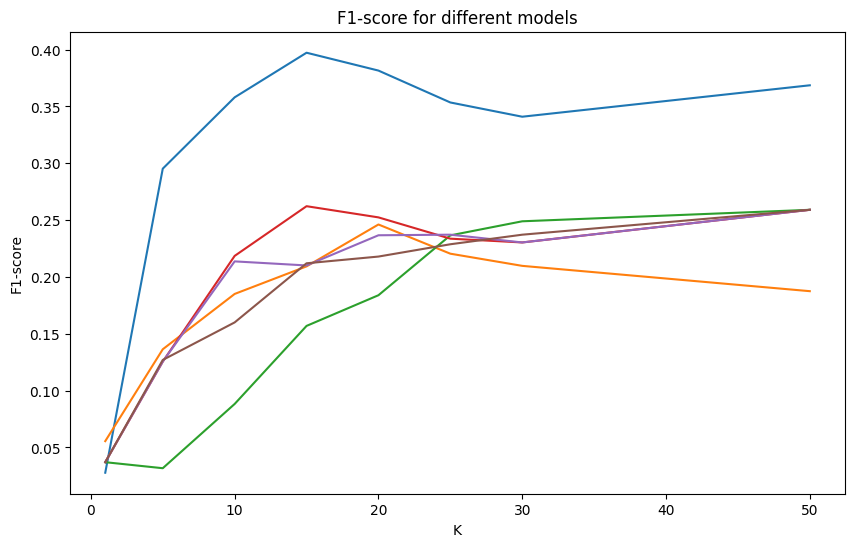

In [33]:
import tikzplotlib

def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)


# get all K values for a given model
def get_model_metrics(model):
    return {k: v for k, v in metrics.items() if k[1] == model}

# plot f1 for all models!
# solid red line for f1-score
import matplotlib.pyplot as plt
def plot_model_metrics():
    fig, ax = plt.subplots(figsize=(10, 6))
    for model in ["sbert", "fasttext", "string", "tfidf", "bm25", "jaccard"]:
        print(model)
        model_metrics = get_model_metrics(model)
        x = [k[0] for k in model_metrics.keys()]
        y = [v["f1_score"] for v in model_metrics.values()]
        print(f"X: {x}")
        print(f"Y: {y}")

        ax.plot(x, y, label=model)
        # ax.scatter(x, y, s=50)

    ax.set_xlabel("K")
    ax.set_ylabel("F1-score")
    ax.set_title("F1-score for different models")
    # ax.legend()
    # plt.show()

    tikzplotlib.save("f1_score.tex")


plot_model_metrics()